# 주제선정: ABC 다국적 은행의 가입고객 이탈예측

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# font_path = '/Library/Fonts/Arial Unicode.ttf'      # mac 폰트 추가
font_path = 'C:\\Windows\\Fonts\\malgun.TTF'          # 한글 폰트를 적용하여 시각화
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

# warnings 무시하기
import warnings
warnings.filterwarnings('ignore')

# 새 csv 파일을 호출
df = pd.read_csv("./data/Preprocessed_Bank_Customer_Churn_Prediction.csv")
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,0,39,5,0.00,2,1,0,96270.64,0
9996,516,0,0,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,1,36,7,0.00,1,0,1,42085.58,1
9998,772,1,0,42,3,75075.31,2,1,0,92888.52,1


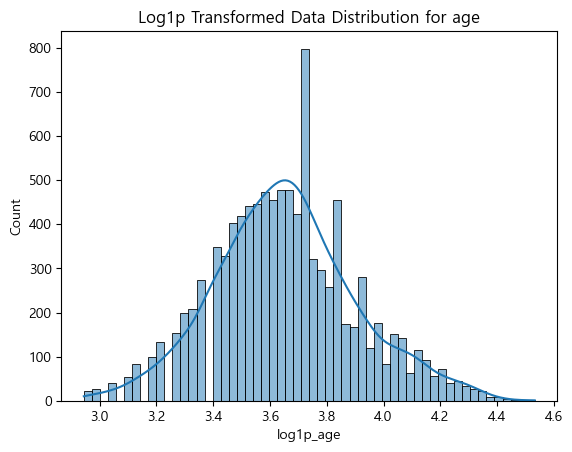

   credit_score  country  gender  age  tenure    balance  products_number  \
0           619        0       1   42       2       0.00                1   
1           608        2       1   41       1   83807.86                1   
2           502        0       1   42       8  159660.80                3   
3           699        0       1   39       1       0.00                2   
4           850        2       1   43       2  125510.82                1   

   credit_card  active_member  estimated_salary  churn  log1p_age  
0            1              1         101348.88      1   3.761200  
1            0              1         112542.58      0   3.737670  
2            1              0         113931.57      1   3.761200  
3            0              0          93826.63      0   3.688879  
4            1              1          79084.10      0   3.784190  
   credit_score  country  gender       age  tenure    balance  \
0           619        0       1  3.761200       2       0.00   

In [27]:
# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['age']                        # 양의 값을 가지는 컬럼 중, 왜도가 높은 'age'만 log 변환 추가

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[f'log1p_{column}'] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

# log1p 변환 후 데이터 분포 시각화
for column in skewed_columns:
    sns.histplot(df[f'log1p_{column}'], kde=True)
    plt.title(f'Log1p Transformed Data Distribution for {column}')
    plt.show()

# 결과 출력
print(df.head())

# 변환된 'log1p_' 컬럼을 원래 컬럼에 대체하고, 불필요한 컬럼 제거
for column in skewed_columns:
    df[column] = df[f'log1p_{column}']
    df.drop([f'log1p_{column}'], axis=1, inplace=True)

# 최종 데이터 확인
print(df.head())

### 평가 함수

In [28]:
def evaluation(model, X_test, y_test, threshold=0.4933):      # 최적 임계값 설정 (Recall 중심)

    # 예측 확률 구하기
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 임계값을 기준으로 예측 결과 도출
    y_pred = (y_prob >= threshold).astype(int)

    # 정확도
    accuracy = accuracy_score(y_test, y_pred)
    print(f"정확도: {accuracy * 100:.4f}%")
    print()

    # 정밀도: 정밀도는 예측한 클래스 1 중에서 실제로 클래스 1인 비율
    precision = precision_score(y_test, y_pred)
    print(f"정밀도: {precision:.4f}")
    print()

    # 재현율: 재현율은 실제 클래스 1 중에서 모델이 클래스 1로 예측한 비율
    recall = recall_score(y_test, y_pred)
    print(f"재현율: {recall:.4f}")
    print()

    # F1 점수: F1 점수는 정밀도와 재현율의 조화 평균, 두 지표의 균형을 맞추기 위한 지표
    f1 = f1_score(y_test, y_pred)
    print(f"F1 점수: {f1:.4f}")
    print()

    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    print("혼동 행렬:\n", cm)
    print()

    # 종합 지표
    report = classification_report(y_test, y_pred)
    print("분류 결과:\n", report)
    print()

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # ROC 곡선 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

---

- AdaBoost

In [29]:
# 데이터 준비
X = df.drop('churn', axis=1)
y = df['churn']

# 데이터 분할 (학습: 70%, 테스트: 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard 정규화
standard_x = StandardScaler()
X_train_standard = standard_x.fit_transform(X_train)
X_test_standard = standard_x.transform(X_test)

In [30]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost 모델 생성
abc = AdaBoostClassifier()

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # 하이퍼파라미터 그리드 생성
# param_grid = {
#     'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
#     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# }

# # GridSearchCV 수행
# grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
# grid_search.fit(X_train_standard, y_train)

# # 최적의 하이퍼파라미터 출력: {'learning_rate': 1, 'n_estimators': 450}
# print(grid_search.best_params_)

{'learning_rate': 1, 'n_estimators': 450}


정확도: 86.1333%

정밀도: 0.6981

재현율: 0.5068

F1 점수: 0.5873

혼동 행렬:
 [[2288  128]
 [ 288  296]]

분류 결과:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      2416
           1       0.70      0.51      0.59       584

    accuracy                           0.86      3000
   macro avg       0.79      0.73      0.75      3000
weighted avg       0.85      0.86      0.85      3000


AUC: 0.8471


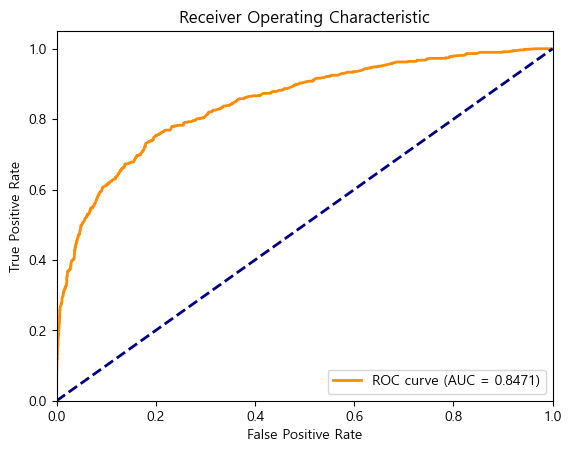

In [ ]:
# 최적의 하이퍼 파라미터: {'learning_rate': 1, 'n_estimators': 450}

# 최적의 하이퍼 파라미터를 기반으로 정의
abc = AdaBoostClassifier(random_state=42, learning_rate=1, n_estimators=450)

# AdaBoost 모델 학습
# abc.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
# evaluation(abc, X_test_standard, y_test)

---

- XGBoost

In [ ]:
# !pip install --upgrade scikit-learn

In [ ]:
# !pip install --upgrade xgboost

In [46]:
from xgboost import XGBClassifier

# XGBoost 모델 생성
xgb = XGBClassifier()

정확도: 86.4000%

정밀도: 0.6600

재현율: 0.6216

F1 점수: 0.6402

혼동 행렬:
 [[2229  187]
 [ 221  363]]

분류 결과:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      2416
           1       0.66      0.62      0.64       584

    accuracy                           0.86      3000
   macro avg       0.78      0.77      0.78      3000
weighted avg       0.86      0.86      0.86      3000


AUC: 0.8676


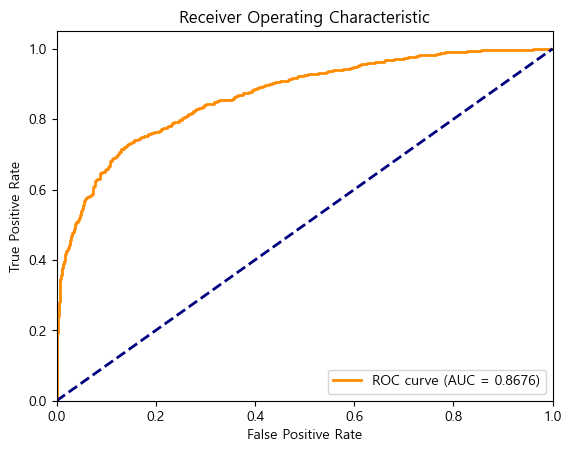

In [ ]:
# 최적의 하이퍼 파라미터를 기반으로 정의
xgb = XGBClassifier(
    colsample_bytree=0.9988,
    learning_rate=0.0591,
    max_depth=4,
    min_child_weight=4,
    n_estimators=152,
    subsample=0.7172,
    scale_pos_weight=1.9,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
    )

# XGBoost 모델 학습
# xgb.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
# evaluation(xgb, X_test_standard, y_test)

---

- CatBoost

In [48]:
from catboost import CatBoostClassifier

# CatBoost 모델 생성
cat = CatBoostClassifier()

정확도: 87.0000%

정밀도: 0.7771

재현율: 0.4658

F1 점수: 0.5824

혼동 행렬:
 [[2338   78]
 [ 312  272]]

분류 결과:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.78      0.47      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000


AUC: 0.8691


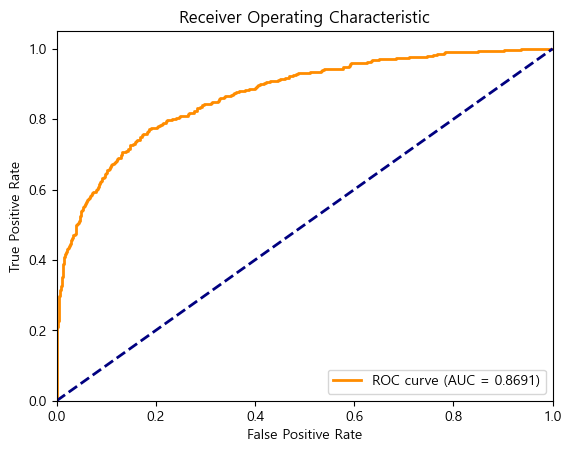

In [ ]:
# 최적의 하이퍼 파라미터를 기반으로 정의
cat = CatBoostClassifier(allow_writing_files=False, random_state=42, depth=4, iterations=100, learning_rate=0.1, verbose=0)

# CatBoost 모델 학습
# cat.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
# evaluation(cat, X_test_standard, y_test)

---

- RandomForest

In [50]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest 모델 생성
rf = RandomForestClassifier()

정확도: 86.9333%

정밀도: 0.7743

재현율: 0.4640

F1 점수: 0.5803

혼동 행렬:
 [[2337   79]
 [ 313  271]]

분류 결과:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.77      0.46      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000


AUC: 0.8625


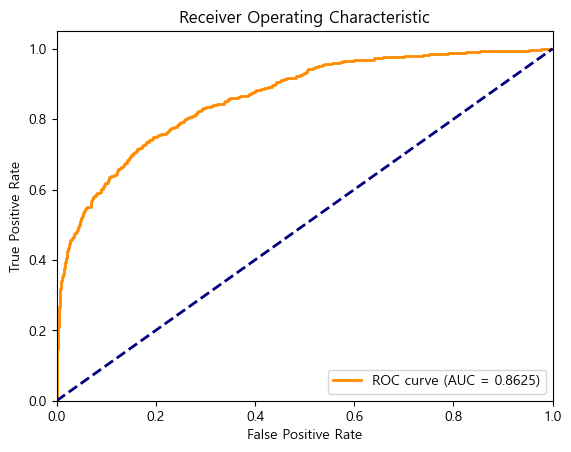

In [ ]:
# 최적의 하이퍼 파라미터를 기반으로 정의
rf = RandomForestClassifier(random_state=42, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200)

# RandomForest 모델 학습
# rf.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
# evaluation(rf, X_test_standard, y_test)

---

- Ensemble (Stacking)

In [52]:
from sklearn.ensemble import StackingClassifier

정확도: 85.9333%

정밀도: 0.6570

재현율: 0.5805

F1 점수: 0.6164

혼동 행렬:
 [[2239  177]
 [ 245  339]]

분류 결과:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      2416
           1       0.66      0.58      0.62       584

    accuracy                           0.86      3000
   macro avg       0.78      0.75      0.77      3000
weighted avg       0.85      0.86      0.86      3000


AUC: 0.8644


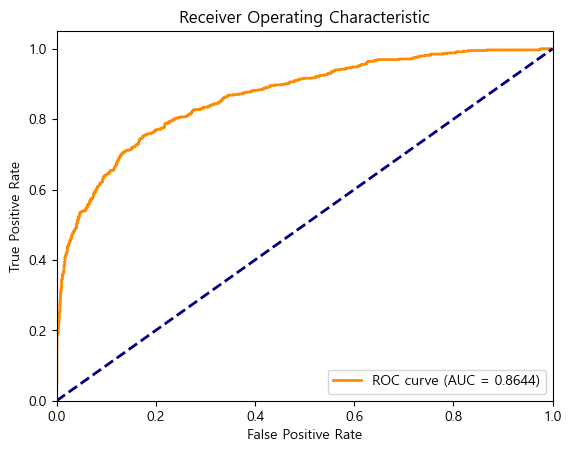

In [ ]:
# 스태킹 모델 정의 (메타 모델: XGBoost, 기본 모델 중복 O)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('cat', cat),
        ('ada', abc)
    ],
    final_estimator=xgb
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 85.8667%

정밀도: 0.6521

재현율: 0.5873

F1 점수: 0.6180

혼동 행렬:
 [[2233  183]
 [ 241  343]]

분류 결과:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2416
           1       0.65      0.59      0.62       584

    accuracy                           0.86      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.85      0.86      0.86      3000


AUC: 0.8661


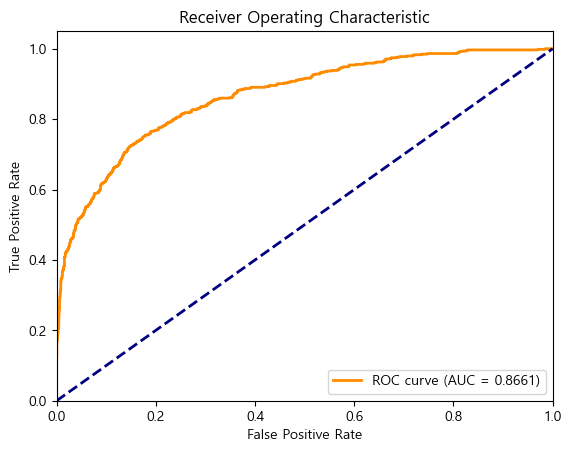

In [ ]:
# 스태킹 모델 정의 (메타 모델: XGBoost, 기본 모델 중복 X)
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('cat', cat),
        ('ada', abc)
    ],
    final_estimator=xgb
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 86.6667%

정밀도: 0.7323

재현율: 0.4966

F1 점수: 0.5918

혼동 행렬:
 [[2310  106]
 [ 294  290]]

분류 결과:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.73      0.50      0.59       584

    accuracy                           0.87      3000
   macro avg       0.81      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000


AUC: 0.8538


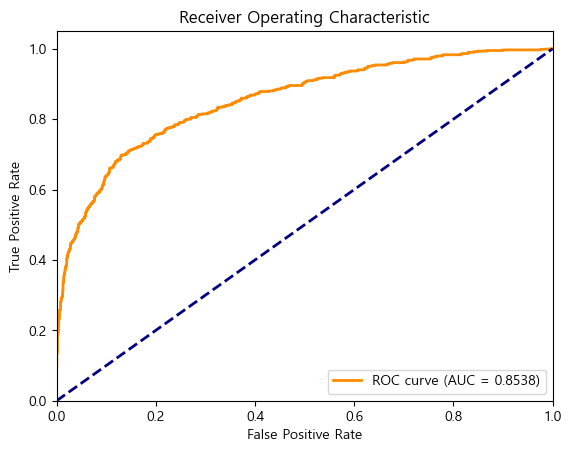

In [ ]:
# 스태킹 모델 정의 (메타 모델: RandomForest, 기본 모델 중복 O)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('cat', cat),
        ('ada', abc)
    ],
    final_estimator=rf
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 86.5667%

정밀도: 0.7268

재현율: 0.4966

F1 점수: 0.5900

혼동 행렬:
 [[2307  109]
 [ 294  290]]

분류 결과:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      2416
           1       0.73      0.50      0.59       584

    accuracy                           0.87      3000
   macro avg       0.81      0.73      0.75      3000
weighted avg       0.86      0.87      0.86      3000


AUC: 0.8510


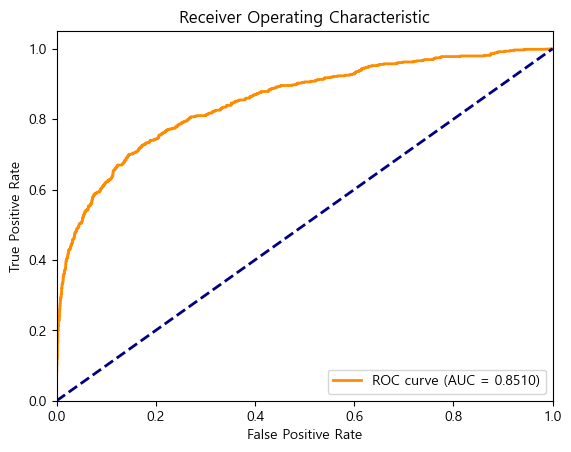

In [ ]:
# 스태킹 모델 정의 (메타 모델: RandomForest, 기본 모델 중복 X)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('ada', abc)
    ],
    final_estimator=rf
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 86.9333%

정밀도: 0.7609

재현율: 0.4795

F1 점수: 0.5882

혼동 행렬:
 [[2328   88]
 [ 304  280]]

분류 결과:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2416
           1       0.76      0.48      0.59       584

    accuracy                           0.87      3000
   macro avg       0.82      0.72      0.76      3000
weighted avg       0.86      0.87      0.86      3000


AUC: 0.8682


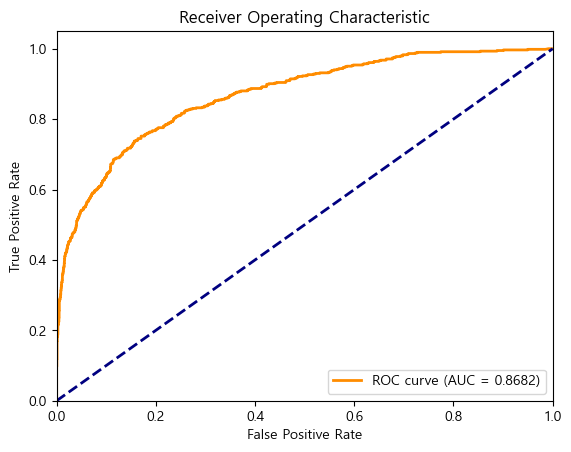

In [ ]:
# 스태킹 모델 정의 (메타 모델: CatBoost, 기본 모델 중복 O)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('cat', cat),
        ('ada', abc)
    ],
    final_estimator=cat
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 87.3667%

정밀도: 0.7763

재현율: 0.4932

F1 점수: 0.6031

혼동 행렬:
 [[2333   83]
 [ 296  288]]

분류 결과:
               precision    recall  f1-score   support

           0       0.89      0.97      0.92      2416
           1       0.78      0.49      0.60       584

    accuracy                           0.87      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.87      0.87      0.86      3000


AUC: 0.8665


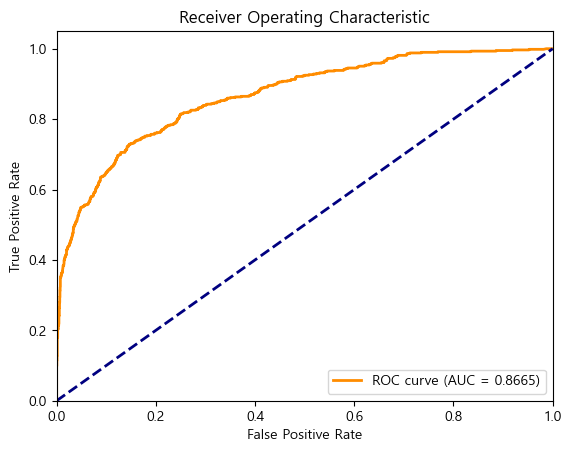

In [ ]:
# 스태킹 모델 정의 (메타 모델: CatBoost, 기본 모델 중복 X)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('ada', abc)
    ],
    final_estimator=cat
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 86.4333%

정밀도: 0.6911

재현율: 0.5479

F1 점수: 0.6113

혼동 행렬:
 [[2273  143]
 [ 264  320]]

분류 결과:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      2416
           1       0.69      0.55      0.61       584

    accuracy                           0.86      3000
   macro avg       0.79      0.74      0.76      3000
weighted avg       0.86      0.86      0.86      3000


AUC: 0.8673


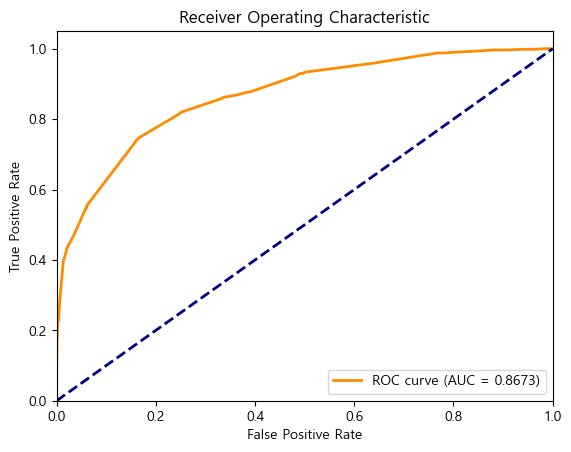

In [ ]:
# 스태킹 모델 정의 (메타 모델: AdaBoost, 기본 모델 중복 O)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('cat', cat),
        ('ada', abc)
    ],
    final_estimator=abc
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)

정확도: 86.4000%

정밀도: 0.6897

재현율: 0.5479

F1 점수: 0.6107

혼동 행렬:
 [[2272  144]
 [ 264  320]]

분류 결과:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      2416
           1       0.69      0.55      0.61       584

    accuracy                           0.86      3000
   macro avg       0.79      0.74      0.76      3000
weighted avg       0.86      0.86      0.86      3000


AUC: 0.8674


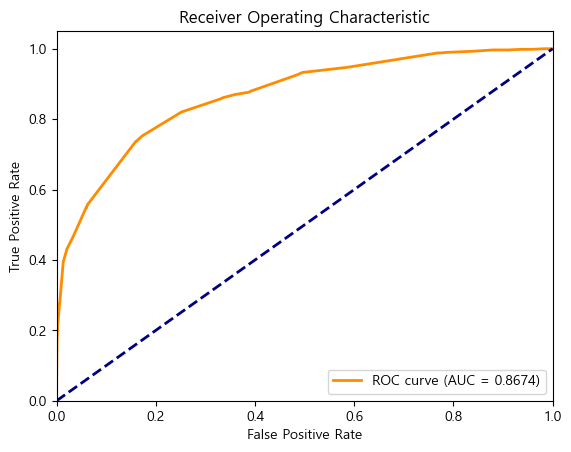

In [ ]:
# 스태킹 모델 정의 (메타 모델: AdaBoost, 기본 모델 중복 X)
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('cat', cat)
    ],
    final_estimator=abc
)

# 정의한 스태킹 모델 학습
stacking_model.fit(X_train_standard, y_train)

# 정확도 평가: Standard 정규화
evaluation(stacking_model, X_test_standard, y_test)